In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Datasets/commentToxic/toxic_train.csv')

In [ ]:
df.head()

,Unnamed: 0,comment_text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
def remove_n(row):
  return row.replace("\n", "")

df['comment_text'] = df['comment_text'].apply(remove_n)

In [ ]:
toxic_df = df[df.toxic.values == 1]
non_toxic_df = df[df.toxic.values == 0]
toxic_df.tail()


,Unnamed: 0,comment_text,toxic
159494,159494,""" our previous conversation you fucking shit e...",1
159514,159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159541,159541,Your absurd edits Your absurd edits on great w...,1
159546,159546,"""Hey listen don't you ever!!!! Delete my edits...",1
159554,159554,and i'm going to keep posting the stuff u dele...,1


In [ ]:
toxic_have = len(toxic_df)
non_toxic_have = len(df[df.toxic.values == 0])
generate_toxic = non_toxic_have - toxic_have

toxic_have, non_toxic_have, generate_toxic

(15294, 144277, 128983)

In [ ]:
non_toxic_list = non_toxic_df.comment_text.to_list()
new_non_toxic_list = []

import random

for item in range(0, 15294):
  sample_index = random.randint(0, 15294-1)
  new_non_toxic_list.append(non_toxic_list[sample_index])

new_non_toxic_target = [0 for i in range(len(new_non_toxic_list))]

len(new_non_toxic_list), len(new_non_toxic_target)

(15294, 15294)

In [ ]:
non_new_toxic_df = pd.DataFrame({
    'comment_text': new_non_toxic_list,
    'toxic': new_non_toxic_target
})

In [ ]:
non_new_toxic_df.head()

,comment_text,toxic
0,"""Excellent! That would be great. The comments ...",0
1,This but a flesh wound,0
2,Firefox I still can't quite figure out what th...,0
3,Note to NishkidYou have blocked me from sendin...,0
4,Who was Ohtahara? I'm assuming (from the name ...,0


In [ ]:
final_toxic_df = pd.concat([toxic_df[['comment_text', 'toxic']], non_new_toxic_df[['comment_text', 'toxic']]], ignore_index=True)

In [ ]:
final_toxic_df.tail()

,comment_text,toxic
30583,UnderstandMexicoWould you please provide an ex...,0
30584,getting your priorities right I don't like the...,0
30585,""" Spventi: """"but perhaps it's safest to discus...",0
30586,"...and if one doesn't, one should refrain from...",0
30587,I think there's little doubt that there is tak...,0


In [ ]:
final_toxic_df.toxic.value_counts()

1    15294
0    15294
Name: toxic, dtype: int64

In [ ]:
# Preprocess
from tensorflow.keras.layers import TextVectorization

x = final_toxic_df['comment_text']
y = final_toxic_df['toxic']

In [ ]:
MAX_FEATURES = 200000 # number of words in vocab

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
				output_sequence_length=1800, output_mode='int')

vectorizer.get_vocabulary()
vectorizer.adapt(x.values)

vectorized_text = vectorizer(x.values)

In [ ]:
import json, pickle
import joblib

pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()}
            , open('/content/drive/My Drive/Datasets/commentToxic/toxic_vectorizer.pkl', "wb"))

# from_disk = pickle.load(open("tv_layer.pkl", "rb"))
# new_v = TextVectorization.from_config(from_disk['config'])
# # You have to call `adapt` with some dummy data (BUG in Keras)
# new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
# new_v.set_weights(from_disk['weights'])


# with open('/content/drive/My Drive/Datasets/commentToxic/toxic_vectorizer.pkl', 'wb') as f:
#     json.dump(vectorizer, f)

In [ ]:
vectorized_text[0]

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([391, 171,   3, ...,   0,   0,   0])>

In [ ]:
# MCSHBAP - map, cache, shuffle, batch, prefetch, from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(20000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(10)

In [ ]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [ ]:
# create Sequential Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()

# create embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extraction layer
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                        

In [ ]:
history = model.fit(train, epochs=3, validation_data=val)

Epoch 1/3
1338/1338 [==============================] - 633s 473ms/step - loss: 0.2868 - val_loss: 0.1563
Epoch 2/3
1338/1338 [==============================] - 648s 484ms/step - loss: 0.1658 - val_loss: 0.0947
Epoch 3/3
1338/1338 [==============================] - 594s 444ms/step - loss: 0.1007 - val_loss: 0.0547


In [ ]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

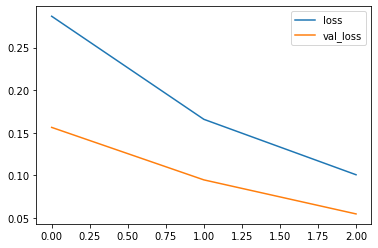

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.984501838684082, Recall:0.9772893786430359, Accuracy:0.14659686386585236


In [ ]:
model.save('/content/drive/My Drive/Datasets/commentToxic/toxic_model.h5')

In [ ]:
input_text = vectorizer(["An easy substitute to tell someone to 'bugger off'"])
res = model.predict(input_text)

In [ ]:
(res > 0.5).astype(int)

array([[1]])